<a href="https://colab.research.google.com/github/MdYeakub-py/Business_report_MySQL/blob/main/python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Syntax

In [ ]:
number_1 = "asd"

# Indentation & Comments

In [ ]:
import os
import os.path
from subprocess import Popen, PIPE
import sys
from threading import Thread
from urllib.parse import urlparse
from urllib.request import urlretrieve
import venv

class ExtendedEnvBuilder(venv.EnvBuilder):

    # This builder installs setuptools and pip so that you can pip or
    # easy_install other packages into the created virtual environment.

    # :param nodist: If true, setuptools and pip are not installed into the
    #                created virtual environment.
    # :param nopip: If true, pip is not installed into the created
    #               virtual environment.
    # :param progress: If setuptools or pip are installed, the progress of the
    #                  installation can be monitored by passing a progress
    #                  callable. If specified, it is called with two
    #                  arguments: a string indicating some progress, and a
    #                  context indicating where the string is coming from.
    #                  The context argument can have one of three values:
    #                  'main', indicating that it is called from virtualize()
    #                  itself, and 'stdout' and 'stderr', which are obtained
    #                  by reading lines from the output streams of a subprocess
    #                  which is used to install the app.

    #                  If a callable is not specified, default progress
    #                  information is output to sys.stderr.


    def __init__(self, *args, **kwargs):
        self.nodist = kwargs.pop('nodist', False)
        self.nopip = kwargs.pop('nopip', False)
        self.progress = kwargs.pop('progress', None)
        self.verbose = kwargs.pop('verbose', False)
        super().__init__(*args, **kwargs)

    def post_setup(self, context):
        """
        Set up any packages which need to be pre-installed into the
        virtual environment being created.

        :param context: The information for the virtual environment
                        creation request being processed.
        """
        os.environ['VIRTUAL_ENV'] = context.env_dir
        if not self.nodist:
          self.install_setuptools(context)
        # Can't install pip without setuptools
        if not self.nopip and not self.nodist:
            self.install_pip(context)

    def reader(self, stream, context):
      """
      Read lines from a subprocess' output stream and either pass to a progress
      callable (if specified) or write progress information to sys.stderr.
      """
      progress = self.progress
      while True:
        s = stream.readline()
        if not s:
            break
        if progress is not None:
            progress(s, context)
        else:
            if not self.verbose:
              sys.stderr.write('.')
            else:
              sys.stderr.write(s.decode('utf-8'))
            sys.stderr.flush()
      stream.close()

    def install_script(self, context, name, url):
        _, _, path, _, _, _ = urlparse(url)
        fn = os.path.split(path)[-1]
        binpath = context.bin_path
        distpath = os.path.join(binpath, fn)
        # Download script into the virtual environment's binaries folder
        urlretrieve(url, distpath)
        progress = self.progress
        if self.verbose:
            term = '\n'
        else:
            term = ''
        if progress is not None:
            progress('Installing %s ...%s' % (name, term), 'main')
        else:
            sys.stderr.write('Installing %s ...%s' % (name, term))
            sys.stderr.flush()
        # Install in the virtual environment
        args = [context.env_exe, fn]
        p = Popen(args, stdout=PIPE, stderr=PIPE, cwd=binpath)
        t1 = Thread(target=self.reader, args=(p.stdout, 'stdout'))
        t1.start()
        t2 = Thread(target=self.reader, args=(p.stderr, 'stderr'))
        t2.start()
        p.wait()
        t1.join()
        t2.join()
        if progress is not None:
            progress('done.', 'main')
        else:
            sys.stderr.write('done.\n')
        # Clean up - no longer needed
        os.unlink(distpath)

    def install_setuptools(self, context):
        """
        Install setuptools in the virtual environment.

        :param context: The information for the virtual environment
                        creation request being processed.
        """
        url = "https://bootstrap.pypa.io/ez_setup.py"
        self.install_script(context, 'setuptools', url)
        # clear up the setuptools archive which gets downloaded
        pred = lambda o: o.startswith('setuptools-') and o.endswith('.tar.gz')
        files = filter(pred, os.listdir(context.bin_path))
        for f in files:
            f = os.path.join(context.bin_path, f)
            os.unlink(f)

    def install_pip(self, context):
        """
        Install pip in the virtual environment.

        :param context: The information for the virtual environment
                        creation request being processed.
        """
        url = 'https://bootstrap.pypa.io/get-pip.py'
        self.install_script(context, 'pip', url)


def main(args=None):
    import argparse

    parser = argparse.ArgumentParser(prog=__name__,
                                     description='Creates virtual Python '
                                                 'environments in one or '
                                                 'more target '
                                                 'directories.')
    parser.add_argument('dirs', metavar='ENV_DIR', nargs='+',
                        help='A directory in which to create the '
                             'virtual environment.')
    parser.add_argument('--no-setuptools', default=False,
                        action='store_true', dest='nodist',
                        help="Don't install setuptools or pip in the "
                             "virtual environment.")
    parser.add_argument('--no-pip', default=False,
                        action='store_true', dest='nopip',
                        help="Don't install pip in the virtual "
                             "environment.")
    parser.add_argument('--system-site-packages', default=False,
                        action='store_true', dest='system_site',
                        help='Give the virtual environment access to the '
                             'system site-packages dir.')
    if os.name == 'nt':
        use_symlinks = False
    else:
        use_symlinks = True
    parser.add_argument('--symlinks', default=use_symlinks,
                        action='store_true', dest='symlinks',
                        help='Try to use symlinks rather than copies, '
                             'when symlinks are not the default for '
                             'the platform.')
    parser.add_argument('--clear', default=False, action='store_true',
                        dest='clear', help='Delete the contents of the '
                                           'virtual environment '
                                           'directory if it already '
                                           'exists, before virtual '
                                           'environment creation.')
    parser.add_argument('--upgrade', default=False, action='store_true',
                        dest='upgrade', help='Upgrade the virtual '
                                             'environment directory to '
                                             'use this version of '
                                             'Python, assuming Python '
                                             'has been upgraded '
                                             'in-place.')
    parser.add_argument('--verbose', default=False, action='store_true',
                        dest='verbose', help='Display the output '
                                             'from the scripts which '
                                             'install setuptools and pip.')
    options = parser.parse_args(args)
    if options.upgrade and options.clear:
        raise ValueError('you cannot supply --upgrade and --clear together.')
    builder = ExtendedEnvBuilder(system_site_packages=options.system_site,
                                   clear=options.clear,
                                   symlinks=options.symlinks,
                                   upgrade=options.upgrade,
                                   nodist=options.nodist,
                                   nopip=options.nopip,
                                   verbose=options.verbose)
    for d in options.dirs:
        builder.create(d)

if __name__ == '__main__':
    rc = 1
    try:
        main()
        rc = 0
    except Exception as e:
        print('Error: %s' % e, file=sys.stderr)
    sys.exit(rc)

# Variables

In [ ]:
counter = 222          # Creates an integer variable
miles   = 33.0         # Creates a floating point variable
name    = 'Data 360'   # Creates a string variable

print(counter)
print(miles)
print(name)

222
33.0
Data 360


In [ ]:
print(counter,miles,name, end=" ")

222 33.0 Data 360 

In [ ]:
name = "A"
Name = "B"
naMe = "C"
NAME = "D"
n_a_m_e = "E"
_name = "F"
name_ = "G"
_name_ = "H"
na56me = "I"

print(name,Name,naMe,NAME,n_a_m_e, NAME, n_a_m_e, _name, name_,_name, na56me)

A B C D E D E F G F I


In [ ]:
# Delete
counter = 100
print(counter)

del counter
print(counter)

100


NameError: name 'counter' is not defined

In [ ]:
age = 25
print(age)

age = 26
print(age)

25
26


In [ ]:
# Case-Sensitivity of Python Variables
age = 20
Age = 30

print( "age =", age )
print( "Age =", Age )

age = 20
Age = 30


In [ ]:
# Multiple Assignment
a=10
b=10
c=10

In [ ]:
a=b=c=10

print(a,b,c)

10 10 10


In [ ]:
print(id(a))
print(id(b))
print(id(c))

134980793401872
134980793402192
134980793402512


In [ ]:
a=10
b=20
c=30

In [ ]:
a,b,c = 10,20,30

print(a)

10


# Data Types

##Numbers

In [ ]:
a = 100
b = 100.0

# print(type(a))

In [ ]:
print(type(b))

In [ ]:
a = 5
print("The type of a", type(a))

b = 40.0
print("The type of b", type(b))

c = 1+3j
print("The type of c", type(c))
print(" c is a complex number", isinstance(1+3j,complex))

In [ ]:
#  Casting Python Variables

x = str(10)    # x will be '10'
y = int(10)    # y will be 10
z = float(10)  # z will be 10.0

print( "x =", x )
print( "y =", y )
print( "z =", z )

##Sequence Type | String | List | Tuple

### String

In [ ]:
str_ = 'string using double quotes'
print(str_)
s = """A multiline
string"""
print(s)

string using double quotes
A multiline
string


In [ ]:
g = 'HELLO'
print(g)

##### img

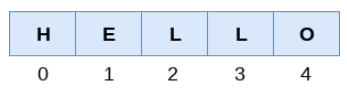

In [ ]:
print(g[0])

ELL


##### img

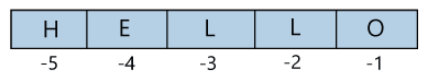

In [ ]:
print(g[-1])

O


In [ ]:
# create a string using double quotes
string1 = "Python programming"

# create a string using single quotes
string1 = 'Python programming'

In [ ]:
# Access String Characters in Python
# Indexing
greet = 'hello'

# access 1st index element
print(greet[1])

In [ ]:
# Negative Indexing
greet = 'hello'

# access 4th last element
print(greet[-4])

In [ ]:
# access character from 1st index to 3rd index
print(greet[1:4])

In [ ]:
# Python Strings are Immutable
message = 'Hola Amigos'
message = 'Aola Amigos'
print(message)

Aola Amigos


In [ ]:
message = 'Hola Amigos'
print(message)


# assign new string to message variable
message = 'Hello Friends'

print(message)

In [ ]:
# Python Multiline String
message = """
Never gonna give you up
Never gonna let you down
"""

print(message)

In [ ]:
# Python String Operations

# Compare Two Strings
str1 = "Hello, world!"
str2 = "I love Swift."
str3 = "Hello, world!"

# compare str1 and str2
print(str1 == str2)

# compare str1 and str3
print(str1 == str3)

True


In [ ]:
# Join Two or More Strings

greet = "Hello, "
name = "Jack"

# using + operator
result = greet + name
print(result)


Hello, Jack


In [ ]:
print('aBC' + 'Def')

aBCDef


In [ ]:
# Iterate Through a Python String

greet = 'Hello'

# iterating through greet string
for letter in greet:
    print(letter)

In [ ]:
print(len(greet))

5


In [ ]:
greet = 'Hello'

# count length of greet string
print(len(greet))

5


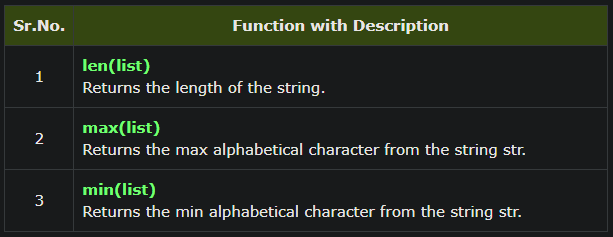

In [ ]:
# String Membership

print('a' in 'program')

print('at' not in 'battle')

False


In [ ]:
capitalize('asas')

'Hello'


1	capitalize()
Capitalizes first letter of string.

2	casefold()
Converts all uppercase letters in string to lowercase. Similar to lower(), but works on UNICODE characters alos.

3	center(width, fillchar)
Returns a space-padded string with the original string centered to a total of width columns.

4	count(str, beg= 0,end=len(string))
Counts how many times str occurs in string or in a substring of string if starting index beg and ending index end are given.

5	decode(encoding='UTF-8',errors='strict')
Decodes the string using the codec registered for encoding. encoding defaults to the default string encoding.

6	encode(encoding='UTF-8',errors='strict')
Returns encoded string version of string; on error, default is to raise a ValueError unless errors is given with 'ignore' or 'replace'.

7	endswith(suffix, beg=0, end=len(string))
Determines if string or a substring of string (if starting index beg and ending index end are given) ends with suffix; returns true if so and false otherwise.

8	expandtabs(tabsize=8)
Expands tabs in string to multiple spaces; defaults to 8 spaces per tab if tabsize not provided.

9	find(str, beg=0 end=len(string))
Determine if str occurs in string or in a substring of string if starting index beg and ending index end are given returns index if found and -1 otherwise.

10	format(*args, **kwargs)
This method is used to format the current string value.

11	format_map(mapping)
This method is also use to format the current string the only difference is it uses a mapping object.

12	index(str, beg=0, end=len(string))
Same as find(), but raises an exception if str not found.

13	isalnum()
Returns true if string has at least 1 character and all characters are alphanumeric and false otherwise.

14	isalpha()
Returns true if string has at least 1 character and all characters are alphabetic and false otherwise.

15	isascii()
Returns True is all the characters in the string are from the ASCII character set.

16	isdecimal()
Returns true if a unicode string contains only decimal characters and false otherwise.

17	isdigit()
Returns true if string contains only digits and false otherwise.

18	isidentifier()
Checks whether the string is a valid Python identifier.

19	islower()
Returns true if string has at least 1 cased character and all cased characters are in lowercase and false otherwise.

20	isnumeric()
Returns true if a unicode string contains only numeric characters and false otherwise.

21	isprintable()
Checks whether all the characters in the string are printable.

22	isspace()
Returns true if string contains only whitespace characters and false otherwise.

23	istitle()
Returns true if string is properly "titlecased" and false otherwise.

24	isupper()
Returns true if string has at least one cased character and all cased characters are in uppercase and false otherwise.

25	join(seq)
Merges (concatenates) the string representations of elements in sequence seq into a string, with separator string.

26	ljust(width[, fillchar])
Returns a space-padded string with the original string left-justified to a total of width columns.

27	lower()
Converts all uppercase letters in string to lowercase.

28	lstrip()
Removes all leading white space in string.

29	maketrans()
Returns a translation table to be used in translate function.

30	partition()
Splits the string in three string tuple at the first occurrence of separator.

31	removeprefix()
Returns a string after removing the prefix string.

32	removesuffix()
Returns a string after removing the suffix string.

33	replace(old, new [, max])
Replaces all occurrences of old in string with new or at most max occurrences if max given.

34	rfind(str, beg=0,end=len(string))
Same as find(), but search backwards in string.

35	rindex( str, beg=0, end=len(string))
Same as index(), but search backwards in string.

36	rjust(width,[, fillchar])
Returns a space-padded string with the original string right-justified to a total of width columns.

37	rpartition()
Splits the string in three string tuple at the ladt occurrence of separator.

38	rsplit()
Splits the string from the end and returns a list of substrings.

39	rstrip()
Removes all trailing whitespace of string.

40	split(str="", num=string.count(str))
Splits string according to delimiter str (space if not provided) and returns list of substrings; split into at most num substrings if given.

41	splitlines( num=string.count('\n'))
Splits string at all (or num) NEWLINEs and returns a list of each line with NEWLINEs removed.

42	startswith(str, beg=0,end=len(string))
Determines if string or a substring of string (if starting index beg and ending index end are given) starts with substring str; returns true if so and false otherwise.

43	strip([chars])
Performs both lstrip() and rstrip() on string.

44	swapcase()
Inverts case for all letters in string.

45	title()
Returns "titlecased" version of string, that is, all words begin with uppercase and the rest are lowercase.

46	translate(table, deletechars="")
Translates string according to translation table str(256 chars), removing those in the del string.

47	upper()
Converts lowercase letters in string to uppercase.

48	zfill (width)
Returns original string leftpadded with zeros to a total of width characters; intended for numbers, zfill() retains any sign given (less one zero).

In [ ]:
# Escape Sequences in Python

example = 'He said, what\'s there?'

print(example)

He said, what's there?


In [ ]:
# escape double quotes
example = "He said, \"What's there?\""

# escape single quotes
example = 'He said, "What\'s there?"'

print(example)

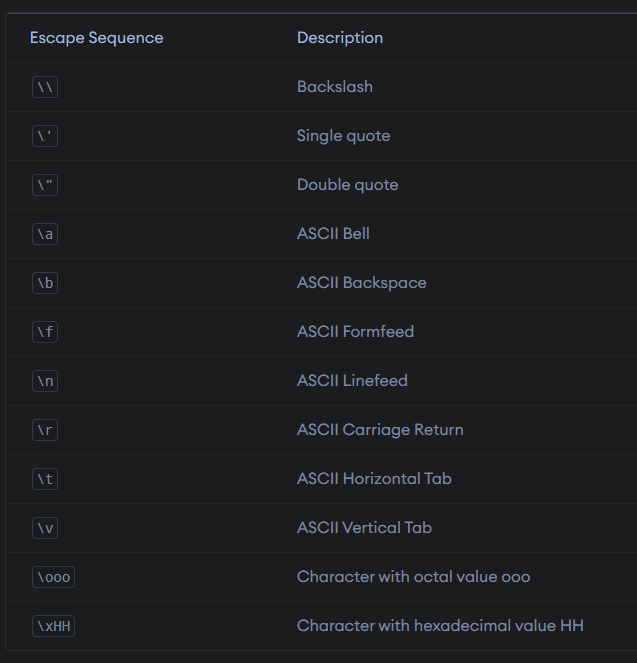

In [ ]:
a = 5
b = 5

sum_ = a + b

print("Sum of 3 + 5 is:", sum_)
print("Sum of", a, " + ", b, "is:", sum_)
print(f"Sum of {a} + {b} is: {sum_}")

Sum of 3 + 5 is: 10
Sum of  5  +  5 is: 10
Sum of 5 + 5 is: 10


In [ ]:
# Python String Formatting (f-Strings)

name = 'Cathy'
country = 'UK'

print(f'{name} is from {country}')

Cathy is from UK


In [ ]:
a = 300
b = 4

r = a + b


print(f'Sum of {a} and {b} is: ', r)


In [ ]:
a = 12
b = 3
print(f'12 multiply 3 is {a * b}.')

###List

In [ ]:
list_1 = 'ABcD'

list_1[2] = 'C'

TypeError: 'str' object does not support item assignment

In [ ]:
list_3 = ["Name", 26, 100.6, list_1]

print(type(list_3))
print(list_3)

<class 'list'>
['Name', 26, 100.6, 'Address']


In [ ]:
list_1 = [9,8,7,6,5,4,3,2,1]

##### img

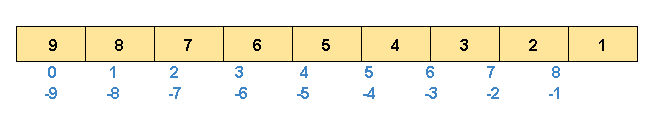

In [ ]:
# Accessing Values in Lists

list1 = ["Rohan", "Physics", 21, 69.75]
list2 = [1, 2, 3, 4, 5]
list3 = ["a", "b", "c", "d"]
list4 = [25.50, True, -55, 1+2j]

In [ ]:

print ("list1[0]: ", list1[-1])
print ("list1[1:3]: ", list_1[2:6])

list1[1:3]:  [21, 69.75]


In [ ]:
# Updating Lists

list_1 = ['physics', 'chemistry', 1997, 2000]
print(list_1)


list_1[2] = 2020
print(list_1)

['physics', 'chemistry', 2020, 2000]


In [ ]:
# Delete List Elements

list1 = ['physics', 'chemistry', 1997, 2000];
print (list1)
del list1[2]

print ("After deleting value at index 2 : ")
print (list1)

In [ ]:
# +
list1 = [11, 22]
list2 = [33, 44]


print(list1 + list2)

print(list1[0] + list2[0])


44


In [ ]:
# *
print(list1 * 4)

str1 = "ABCDEF"

print("C" not in str1)

print('c' in [1,2,'c'])

10


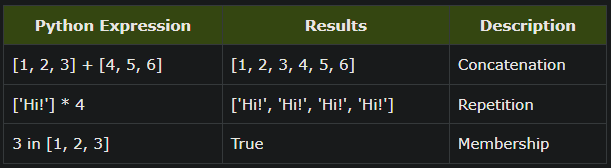

In [ ]:
# Slicing

L = ['spam', 'Spam', 'SPAM!']
L[2]
L[-2]
L[1:]

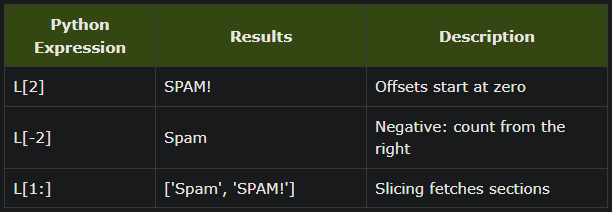

In [ ]:
# append() Method
aList = ['123', 'xyz', 'zara', 'abc']

aList.append(9090)

print("Updated List : ", aList)

Updated List :  ['123', 'xyz', 'zara', 'abc', 9090]


In [ ]:
# Creating an integer list
nums = [1, 2, 3, 4]
# Displaying the list
print('List Before Appending:')
print(nums)

# Appending an element to the nums
# 5 will be added at the end of the nums
nums.append(5)
# Displaying the list
print('List After Appending:')
print(nums)

In [ ]:
# Change List Items

list3 = [1, 2, 3, 4, 5]
print ("Original list ", list3)
list3[2] = 10
print ("List after changing value at index 2: ", list3)

In [ ]:
# Change Consecutive List Items

list1 = ["a", "b", "e" ,"c", "d"]

print ("Original list: ", list1)

# list1[1] = 'Y'
# list1[2] = 'Z'

list2 = ['Y', 'Z']

list1[1:2] = list2


print ("List after changing with sublist: ", list1)

In [ ]:
# index() Method

aList = [123, 'xyz', 'zara', 'abc'];

aList.pop()

print("Index for xyz : ", aList.index( 'xyz' ))
print("Index for zara : ", aList.index( 'zara' ))

2

In [ ]:
# Add List Items

list1 = ["a", "b", "c", "d"]
print ("Original list: ", list1)
list1.append('e')
print ("List after appending: ", list1)

In [ ]:
# Adding List Items Using insert() Method

list1 = ["Rohan", "Physics", 21, 69.75]

list1.insert(2, 'Chemistry')
print ("List after appending: ", list1)



In [ ]:
# remove() Method

aList = [123, 'xyz', 'zara', 'abc', 'xyz']
aList.remove('xyz')
print("List : ", aList)


aList.remove('abc')
print("List : ", aList)

In [ ]:
#  sort() method

list1 = ['physics', 'Biology', 'chemistry', 'maths']
print ("list before sort:", list1)
list1.sort()
print ("list after sort : ", list1)

list before sort: ['physics', 'Biology', 'chemistry', 'maths']
list after sort :  ['Biology', 'chemistry', 'maths', 'physics']


In [ ]:
list2 = [10, 16, 9, 24, 5]
print ("list before sort", list2)

list2.sort()
print ("list after sort : ", list2)

list before sort [10, 16, 9, 24, 5]
list after sort :  [5, 9, 10, 16, 24]


In [ ]:
# Loop Through List Items

lst = [25, 12, 10, -21, 10, 100]
for num in lst:
   print (num, end = ' ')

In [ ]:
# Loop Through List Items with Index

lst = [25, 12, 10, -21, 10, 100]
indices = range(len(lst))
for i in indices:
   print ("lst[{}]: ".format(i), lst[i])

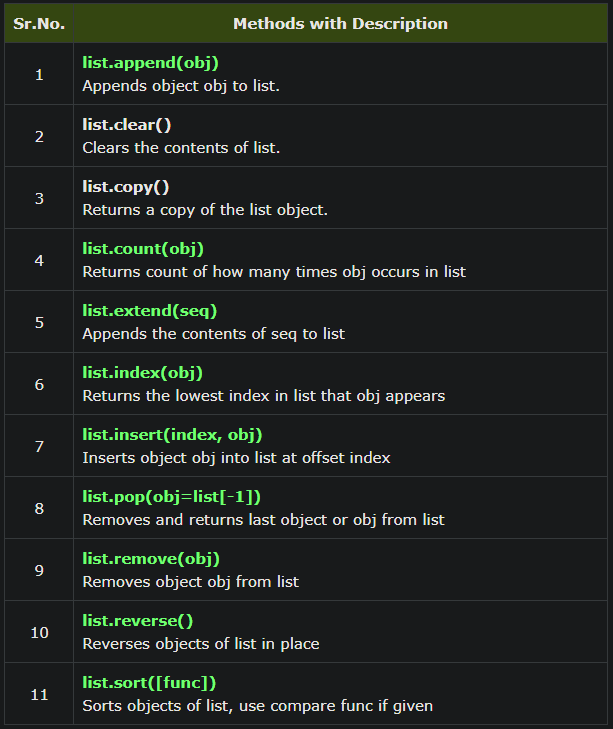

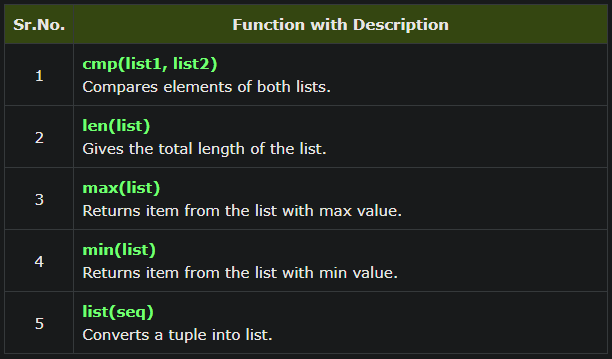

In [ ]:
# Iterate using List Comprehension
# [expression for item in iterable]

numbers = [1, 2, 3, 4, 5]
squared_numbers = [num ** 2 for num in numbers]
print (squared_numbers)


In [ ]:
# Iterate using the enumerate() Function
# for index, item in enumerate(iterable):

for index, item in enumerate(iterable):
  fruits = ["apple", "banana", "cherry"]

for index, fruit in enumerate(fruits):
   print(index, fruit)

* expression is the operation or transformation to apply to each item in the iterable.
* item is the variable representing each element in the iterable.
* iterable is the sequence of elements to iterate over.
* condition (optional) is an expression that filters elements based on a specified condition.

In [ ]:
string = "hello world"
uppercase_letters = [char.upper() for char in string if char.isalpha()]
print(uppercase_letters)

In [ ]:
# Lambda

original_list = [1, 2, 3, 4, 5]
doubled_list = [(lambda x: x * 2)(x) for x in original_list]
print(doubled_list)

In [ ]:
# Nested Loops in Python List Comprehension

list1=[1,2,3]
list2=[4,5,6]
CombLst=[(x,y) for x in list1 for y in list2]
print (CombLst)

In [ ]:
# Conditionals in Python List Comprehension

list1=[x for x in range(1,21) if x%2==0]
print (list1)

List comprehensions are often preferred for simpler operations, while for loops offer more flexibility for complex tasks.

### Tuple

In [ ]:
l = (1.0 , 2, 'A' , True)

(1.0, 2, 'A', True)

In [ ]:
tup  = ("hi", "Python", 2)
# Checking type of tup
print (type(tup))

#Printing the tuple
print (tup)

# Tuple slicing
print (tup[1:])
print (tup[0:1])

# Tuple concatenation using + operator
print (tup + tup)

# Tuple repatation using * operator
print (tup * 3)

# Adding value to tup. It will throw an error.
t[2] = "hi"

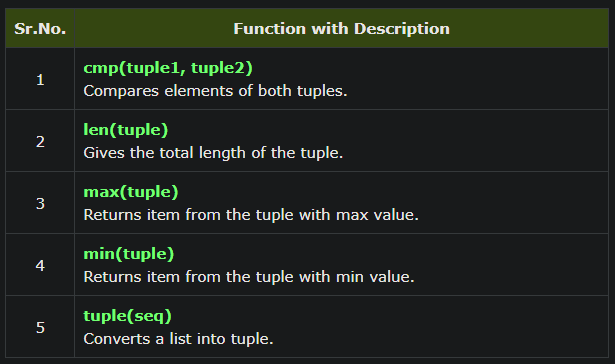

## Dictionary

key : value

Unordered − The elements in a dictionary do not have a specific order. Python dictionaries before version 3.7 did not maintain insertion order. Starting from Python 3.7, dictionaries maintain insertion order as a language feature.

Mutable − You can change, add, or remove items after the dictionary has been created.

Indexed − Although dictionaries do not have numeric indexes, they use keys as indexes to access the associated values.

Unique Keys − Each key in a dictionary must be unique. If you try to assign a value to an existing key, the old value will be replaced by the new value.

Heterogeneous − Keys and values in a dictionary can be of any data type.

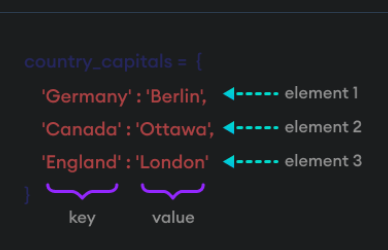

In [ ]:
dic_1 = {
    'one': 1111,
    2:"two",
    3:"three",
    4:"four",
    5:[1,2,'A']
}

type(dic_1)

dict

In [ ]:
# creating a dictionary
country_capitals = {
  "Germany": "Berlin",
  "Canada": "Ottawa",
  "England": "London"
}

# printing the dictionary
print(country_capitals)


dict_keys(['Germany', 'Canada', 'England'])

In [ ]:
list_1 [1,2,3, [1,2,3]]

list_1[0][]

In [ ]:
d1 = {1:'Jimmy',
     2:'Alex',
     'th':'john',
     4:{1:'Jimmy',
        2:'Alex',
        'th':'john',
        4:'mike'}
      }

# Printing dictionary
print (d1['th'])

print (d1.keys())
print (d1.values())

In [ ]:
d1[4]['th']

'john'

In [ ]:
# Creating a dictionary using the dict() function

student_info = dict(name="Alice",
                    age=21,
                    major="Computer Science")

print("Dictionary using dict():",student_info)

Dictionary using dict(): {'name': 'Alice', 'age': 21, 'major': 'Computer Science'}


In [ ]:
type(student_info)

dict

In [ ]:
# Accessing Dictionary Items

student_info = {
   "name": "Alice",
   "age": 21,
   "major": "Computer Science"
}
# Accessing values using square brackets
# name = student_info["name"]
print(student_info["name"])



In [ ]:
# Accessing values using the get() method
age = student_info.get("age")
print("Age:",age)

In [ ]:
# Modifying Dictionary Items

student_info = {
   "name": "Alice",
   "age": 21,
   "major": "Computer Science"
}
# Modifying an existing key-value pair
student_info["age"] = 22

student_info

{'name': 'Alice', 'age': 22, 'major': 'Computer Science'}

In [ ]:
# Adding a new key-value pair
student_info["graduation_year"] = 2023

print("The modified dictionary is:",student_info)

The modified dictionary is: {'name': 'Alice', 'age': 22, 'major': 'Computer Science', 'graduation_year': 2023}


In [ ]:
# Removing Dictionary Items

student_info = {
   "name": "Alice",
   "age": 22,
   "major": "Computer Science",
   "graduation_year": 2023
}
# Removing an item using the del statement
del student_info["major"]

# Removing an item using the pop() method
graduation_year = student_info.pop("graduation_year")

print(student_info)

In [ ]:
# Iterating Through a Dictionary

student_info = {
   "name": "Alice",
   "age": 22,
   "major": "Computer Science",
   "graduation_year": 2023
}
# Iterating through keys
for key in student_info:
   print("Keys:",key, student_info[key])
  # print(key)



Keys: name Alice
Keys: age 22
Keys: major Computer Science
Keys: graduation_year 2023


In [ ]:
# Iterating through values
for value in student_info.values():
   print("Values:",value)



In [ ]:
# Iterating through key-value pairs
for key, value in student_info.items():
   print("Key:Value:",key, value)

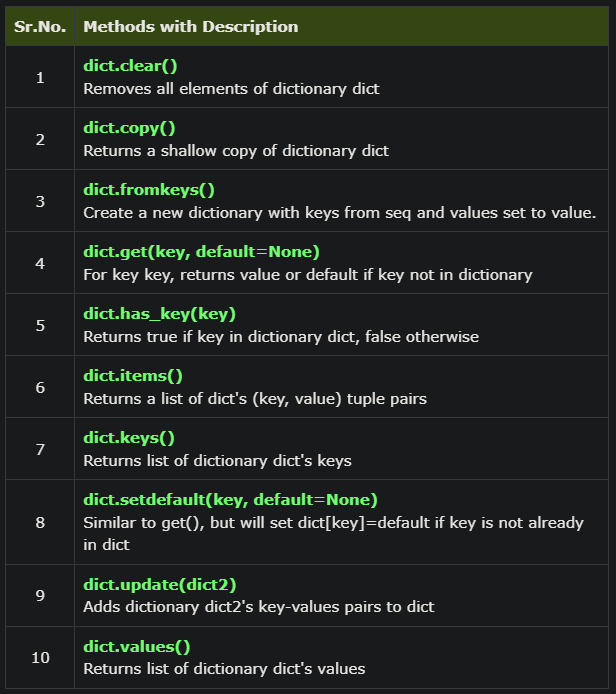

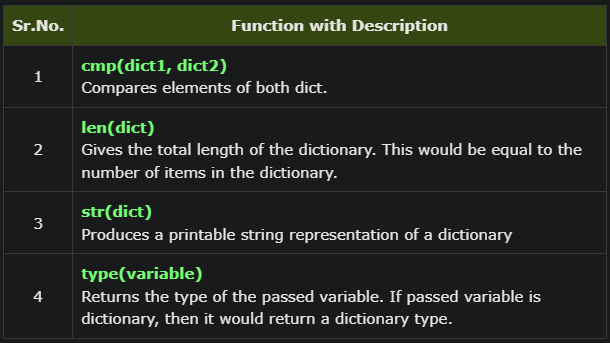

* Access Dictionary Items:
* Using square brackets []
* The get() method
* Iterating through the dictionary using loops
* specific methods like keys(), values(), and items()

In [ ]:
# Access Dictionary Items Using Square Brackets []

capitals = {"Maharashtra":"Mumbai", "Gujarat":"Gandhinagar", "Telangana":"Hyderabad", "Karnataka":"Bengaluru"}
print ("Capital of Gujarat is : ", capitals['Gujarat'])
print ("Capital of Karnataka is : ", capitals['Karnataka'])


In [ ]:
# Access Dictionary Items Using get() Method by Val = dict.get("key")

capitals = {"Maharashtra":"Mumbai", "Gujarat":"Gandhinagar", "Telangana":"Hyderabad", "Karnataka":"Bengaluru"}
print ("Capital of Gujarat is: ", capitals.get('Gujarat'))
print ("Capital of Karnataka is: ", capitals.get('Karnataka'))

In [ ]:
# Access Dictionary Keys

# Creating a dictionary with keys and values
student_info = {
    "name": "Alice",
    "age": 21,
    "major": "Computer Science"
}
# Accessing all keys using the keys() method
all_keys = student_info.keys()
print("Keys:", all_keys)

In [ ]:
# Access Dictionary Items Using the items() Function

# Creating a dictionary with student information
student_info = {
    "name": "Alice",
    "age": 21,
    "major": "Computer Science"
}

# Using the items() method to get key-value pairs
all_items = student_info.items()
print("Items:", all_items)




In [ ]:
# Iterating through the key-value pairs
print("Iterating through key-value pairs:")
for key, value in all_items:
    print(f"{key}: {value}")

In [ ]:
# Modifying Dictionary Values

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Modifying the value associated with the key 'age'
person['age'] = 26
print(person)

In [ ]:
# Updating Multiple Dictionary Values

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Updating multiple values
person.update({'age': 26, 'city': 'Los Angeles'})
print(person)

In [ ]:
# Conditional Dictionary Modification

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Conditionally modifying the value associated with 'age'
if person['age'] == 25:
   person['age'] = 26
print(person)

In [ ]:
# Modify Dictionary by Adding New Key-Value Pairs

# Initial dictionary
person = {'name': 'Alice', 'age': 25}
# Adding a new key-value pair 'city': 'New York'
person['city'] = 'New York'
print(person)

In [ ]:
# Modify Dictionary by Removing Key-Value Pairs

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Removing the key-value pair associated with the key 'age'
del person['age']
print(person)


In [ ]:
# Using the pop() Method

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Removing the key-value pair associated with the key 'age'
removed_age = person.pop('age')

print(person)
print("Removed age:", removed_age)

In [ ]:
# Using the popitem() Method

# Initial dictionary
person = {'name': 'Alice', 'age': 25, 'city': 'New York'}
# Removing the last key-value pair
removed_item = person.popitem()

print(person)
print("Removed item:", removed_item)

## Set

In [ ]:
list_1 = [1, 2, 3, 1, 2, 1, 1]


set1 = set(list_1)
print(set1)

{1, 2, 3}


In [ ]:
# Creating Empty set
set1 = set()

set2 = {1, 2, 3, 1, 2, 1, 1}

#Printing Set value
print(type(set2))
print(set2)


# # Adding element to the set

set2.add(10)
print(set2)


# #Removing element from the set
# set2.remove(2)
# print(set2)

<class 'set'>
{1, 2, 3}


## Boolean

In [ ]:
# Python program to check the boolean type
print(type(True))
print(type(False))

<class 'bool'>


## Type Casting

In [ ]:
a = True
b = 10.5
c = a+b

print(c)

11.5


In [ ]:
a = int(10.5) #converts a float object to int
type(a)

int

In [ ]:
a = int(2*3.14) #expression results float, is converted to int
a

type(a)

In [ ]:
str1 = '100u'

# str1.str.strip().str.replace()

int_from_str = int(str1[0:2])
type(int_from_str)


int

In [ ]:
a = int("100")
type(a)

ValueError: invalid literal for int() with base 10: '100u'

In [ ]:
a = ("10"+"01")
print(a)

a = int("10") + int("01")
print(type(a), a)

<class 'int'> 11


In [ ]:
a = int("10.5")
type(a)

In [ ]:
a = int("Hello World")
a

In [ ]:
a = int(1)     # a will be 1
b = int(2.2)   # b will be 2
c = int("3")   # c will be 3

print (a)
print (b)
print (c)

In [ ]:
a = float(10)
type(a)
a

In [ ]:
a = str(10)
print(type(a), a)

In [ ]:
a=str('True')

type(a)

In [ ]:
# Conversion of Sequence Types

a=[1,2,3,4,5]   # List Object
b=(1,2,3,4,5)   # Tupple Object
c="Hello"       # String Object


In [ ]:
x = list(c)
print(x)

['H', 'e', 'l', 'l', 'o']


In [ ]:
x = list(b)
x

In [ ]:
x=tuple(c)
x

In [ ]:
list_1 = [22,33,44,22,11,55]

new_list = set(list_1)

new_list


1	Python int() function
Converts x to an integer. base specifies the base if x is a string.

2	Python long() function
Converts x to a long integer. base specifies the base if x is a string.

3	Python float() function
Converts x to a floating-point number.

4	Python complex() function
Creates a complex number.

5	Python str() function
Converts object x to a string representation.

6	Python repr() function
Converts object x to an expression string.

7	Python eval() function
Evaluates a string and returns an object.

8	Python tuple() function
Converts s to a tuple.

9	Python list() function
Converts s to a list.

10	Python set() function
Converts s to a set.

11	Python dict() function
Creates a dictionary. d must be a sequence of (key,value) tuples.

12	Python frozenset() function
Converts s to a frozen set.

13	Python chr() function
Converts an integer to a character.

14	Python unichr() function
Converts an integer to a Unicode character.

15	Python ord() function
Converts a single character to its integer value.

16	Python hex() function
Converts an integer to a hexadecimal string.

17	Python oct() function
Converts an integer to an octal string.

# Operators

Python operators are special symbols used to perform specific operations on one or more operands. The variables, values, or expressions can be used as operands. For example, Python's addition operator (+) is used to perform addition operations on two variables, values, or expressions.

* Unary operators: Python operators that require one operand to perform a specific operation are known as unary operators.
* Binary operators: Python operators that require two operands to perform a specific operation are known as binary operators.
* Operands: Variables, values, or expressions that are used with the operator to perform a specific operation.

Types of Python Operators:

* Arithmetic Operators
* Comparison (Relational) Operators
* Assignment Operators
* Logical Operators
* Bitwise Operators
* Membership Operators
* Identity Operators               

## Arithmetic Operators

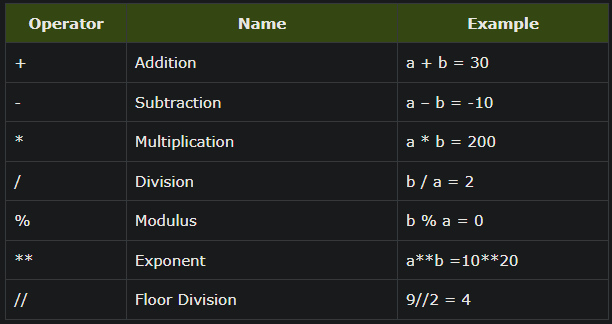

In [ ]:
a = 21
b = 10
c = 0

c = a + b
print ("a: {} b: {} a+b: {}".format(a,b,c))

c = a - b
print ("a: {} b: {} a-b: {}".format(a,b,c))

c = a * b
print ("a: {} b: {} a*b: {}".format(a,b,c))

c = a / b
print ("a: {} b: {} a/b: {}".format(a,b,c))

c = a % b
print ("a: {} b: {} a%b: {}".format(a,b,c))

a = 2
b = 3
c = a**b
print ("a: {} b: {} a**b: {}".format(a,b,c))

a = 10
b = 5
c = a//b
print ("a: {} b: {} a//b: {}".format(a,b,c))

## Comparison Operators

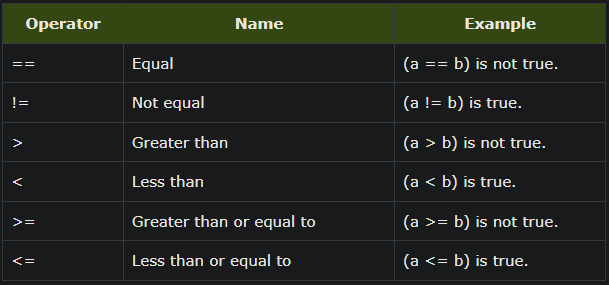

In [ ]:
a = 21
b = 10
if ( a == b ):
   print ("Line 1 - a is equal to b")
else:
   print ("Line 1 - a is not equal to b")

if ( a != b ):
   print ("Line 2 - a is not equal to b")
else:
   print ("Line 2 - a is equal to b")

if ( a < b ):
   print ("Line 3 - a is less than b" )
else:
   print ("Line 3 - a is not less than b")

if ( a > b ):
   print ("Line 4 - a is greater than b")
else:
   print ("Line 4 - a is not greater than b")

a,b=b,a #values of a and b swapped. a becomes 10, b becomes 21

if ( a <= b ):
   print ("Line 5 - a is either less than or equal to  b")
else:
   print ("Line 5 - a is neither less than nor equal to  b")

if ( b >= a ):
   print ("Line 6 - b is either greater than  or equal to b")
else:
   print ("Line 6 - b is neither greater than  nor equal to b")

## Assignment Operators

In [ ]:
a = 10

a = a + 1
a+=1


a

11

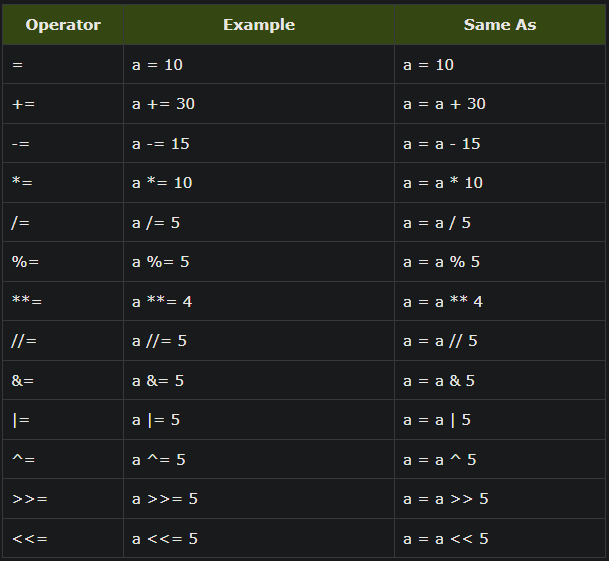

In [ ]:
a = 3

# a = a + 1 || a+=1

In [ ]:
a = 21
b = 10
c = 0
print ("a: {} b: {} c : {}".format(a,b,c))
c = a + b
print ("a: {}  c = a + b: {}".format(a,c))

c += a
print ("a: {} c += a: {}".format(a,c))

c *= a
print ("a: {} c *= a: {}".format(a,c))

c /= a
print ("a: {} c /= a : {}".format(a,c))

c  = 2
print ("a: {} b: {} c : {}".format(a,b,c))
c %= a
print ("a: {} c %= a: {}".format(a,c))

c **= a
print ("a: {} c **= a: {}".format(a,c))

c //= a
print ("a: {} c //= a: {}".format(a,c))

## Bitwise Operators

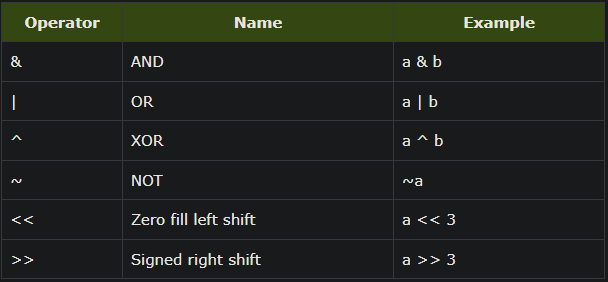

In [ ]:
a = 20
b = 10

print ('a=',a,':',bin(a),'b=',b,':',bin(b))
c = 0

c = a & b;
print ("result of AND is ", c,':',bin(c))

c = a | b;
print ("result of OR is ", c,':',bin(c))

c = a ^ b;
print ("result of EXOR is ", c,':',bin(c))

c = ~a;
print ("result of COMPLEMENT is ", c,':',bin(c))

c = a << 2;
print ("result of LEFT SHIFT is ", c,':',bin(c))

c = a >> 2;
print ("result of RIGHT SHIFT is ", c,':',bin(c))

## Logical Operators

In [ ]:
print(not True)

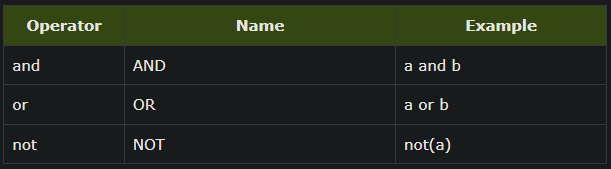

In [ ]:
var = 1

print(var > 3 or var < 10)

print(var > 3 or var < 4)
print(not (var > 3 and var < 10))

True


## Membership Operators

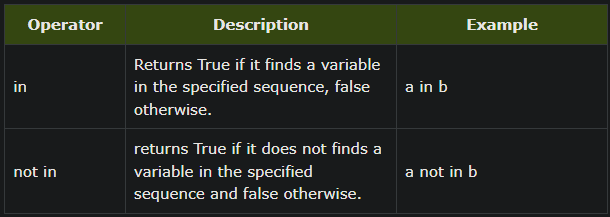

In [ ]:
a = 10
b = 20
list = [1, 2, 3, 4, 5 ]

print ("a:", a, "b:", b, "list:", list)

if ( a in list ):
   print ("a is present in the given list")
else:
   print ("a is not present in the given list")

if ( b not in list ):
   print ("b is not present in the given list")
else:
   print ("b is present in the given list")

c=b/a
print ("c:", c, "list:", list)
if ( c in list ):
   print ("c is available in the given list")
else:
    print ("c is not available in the given list")

## Identity Operators

* 'is' Operator
* 'is not' Operator

In [ ]:
a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
c = a

# Comparing and printing return values
print(a is c)
print(a is b)

# Printing IDs of a, b, and c
print("id(a) : ", id(a))
print("id(b) : ", id(b))
print("id(c) : ", id(c))

In [ ]:
a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
c = a

# Comparing and printing return values
print(a is not c)
print(a is not b)

# Printing IDs of a, b, and c
print("id(a) : ", id(a))
print("id(b) : ", id(b))
print("id(c) : ", id(c))

In [ ]:
a="data"
b=a
print ("id(a), id(b):", id(a), id(b))
print ("a is b:", a is b)
print ("b is not a:", b is not a)

In [ ]:
a=[1,2,3]
b=[1,2,3]
print ("id(a), id(b):", id(a), id(b))
print ("a is b:", a is b)
print ("b is not a:", b is not a)

## Operators Precedence

1	(),[], {}
Parentheses and braces

2	[index], [index:index]
Subscription, slicing,

3	await x
Await expression

4	**
Exponentiation

5	+x, -x, ~x
Positive, negative, bitwise NOT

6	*, @, /, //, %
Multiplication, matrix multiplication, division, floor division, remainder

7	+, -
Addition and subtraction

8	<<, >>
Left Shifts, Right Shifts

9	&
Bitwise AND

10	^
Bitwise XOR

11 |
Bitwise OR

12	in, not in, is, is not, <, <=, >, >=, !=, ==
Comparisons, including membership tests and identity tests

13 not x
Boolean NOT

14 and
Boolean AND

15 or
Boolean OR

16 if – else
Conditional expression

17 lambda
Lambda expression

In [ ]:
a = 20
b = 10
c = 15
d = 5
e = 0

e = (a + b) * c / d       #( 30 * 15 ) / 5
print ("Value of (a + b) * c / d is ",  e)

e = ((a + b) * c) / d     # (30 * 15 ) / 5
print ("Value of ((a + b) * c) / d is ",  e)

e = (a + b) * (c / d);    # (30) * (15/5)
print ("Value of (a + b) * (c / d) is ",  e)

e = a + (b * c) / d;      #  20 + (150/5)
print ("Value of a + (b * c) / d is ",  e)

# input()

In [ ]:
name = input()
city = input()

print ("Hello My name is", name)
print ("I am from ", city)

acbd
dhaka
Hello My name is acbd
I am from  dhaka


In [ ]:
name = input("Enter your name : ")
city = input("Enter your city : ")

print ("Hello My name is", name)
print ("I am from ", city)

In [ ]:
width = input()
height = input()

area = width * height

print(area)


In [ ]:
# Taking Numeric Input in Python

width = input("Enter width : ")
height = input("Enter height : ")

area = width*height
print ("Area of rectangle = ", area)

In [ ]:
w = input("Enter width : ")
width = int(w)

h = input("Enter height : ")
height = int(h)

area = width*height
print ("Area of rectangle = ", area)

In [ ]:
width = int(input("Enter width : "))
height = int(input("Enter height : "))

area = width*height
print ("Area of rectangle = ", area)

# Control Flow

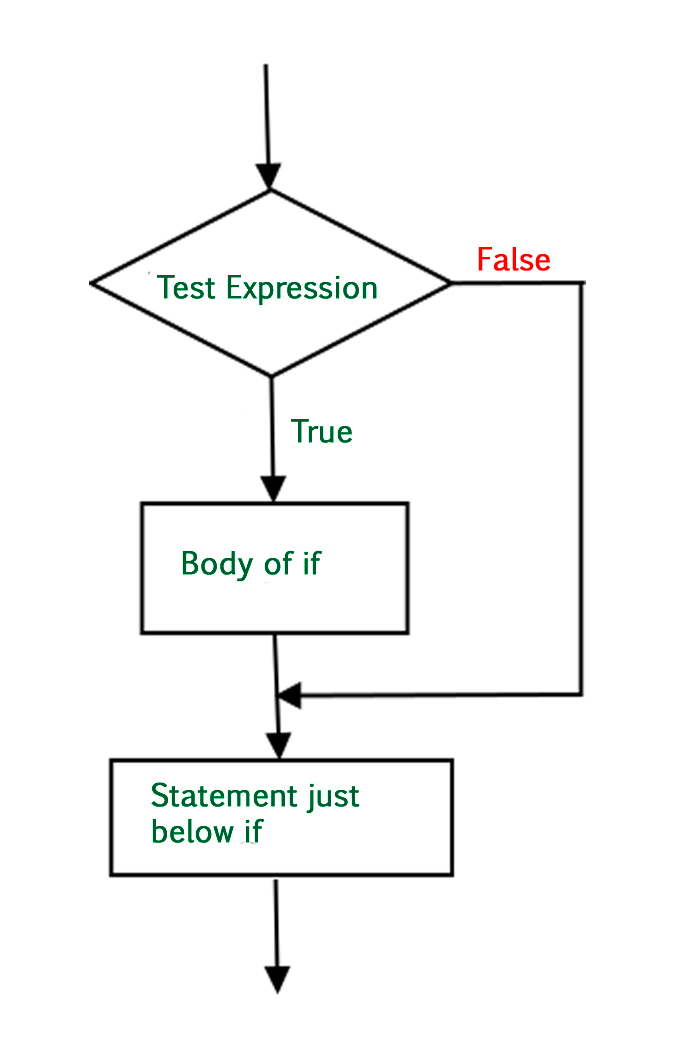

## if Statement



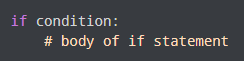

In [ ]:
a = -3

if a>0:
  print('+')
else:
  print('-')

print('--------')

-


In [ ]:
a = 4

if a>100:
  print('Big')

print("-----------")

-----------


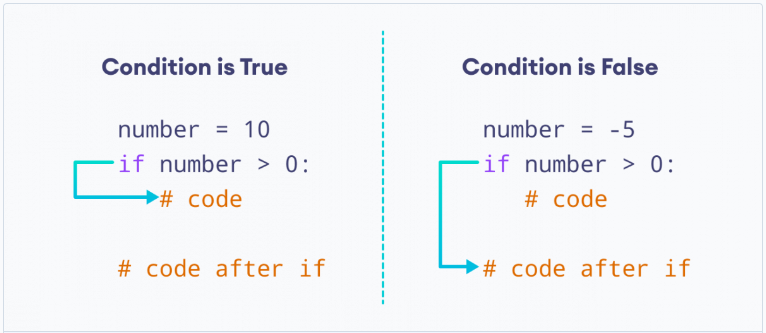

In [ ]:
number = -5

# check if number is greater than 0
if number > 0:
    print(f'{number} is a positive number.')

print('A statement outside the if statement.')

##  if...else Statement

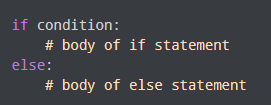

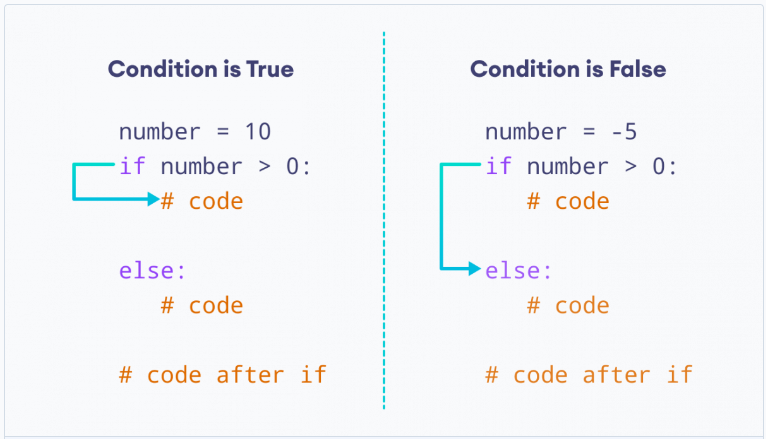

In [ ]:
n = 60

if n >= 50 and n <= 59:
  print('D')

elif n >= 60 and n <= 69:
  print('C')

elif n >= 70 and n <= 79:
  print('B')

elif n >= 80 and n <= 89:
  print('A')
else:
    "A+"


In [ ]:
number = int(input('Enter a number: '))

if number > 0:
    print('Positive number')
else:
    print('Not a positive number')

print('This statement always executes')

## if…elif…else Statement

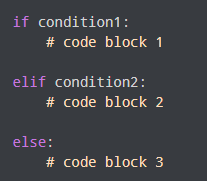

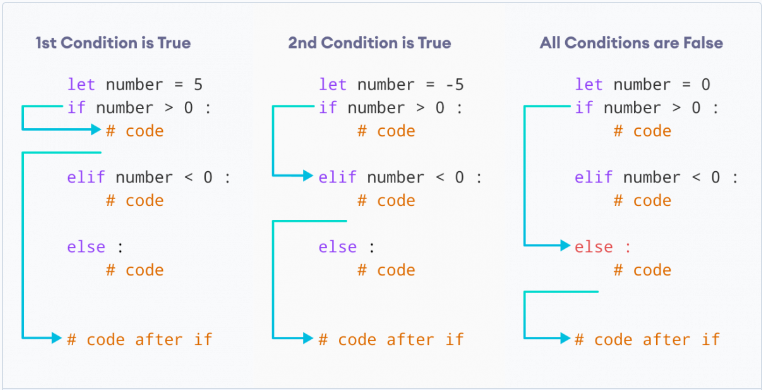

In [ ]:
number = 5

if number > 0:
    print('Positive number')

elif number < 0:
    print('Negative number')

else:
    print('Zero')

print('This statement is always executed')

## Nested if Statements

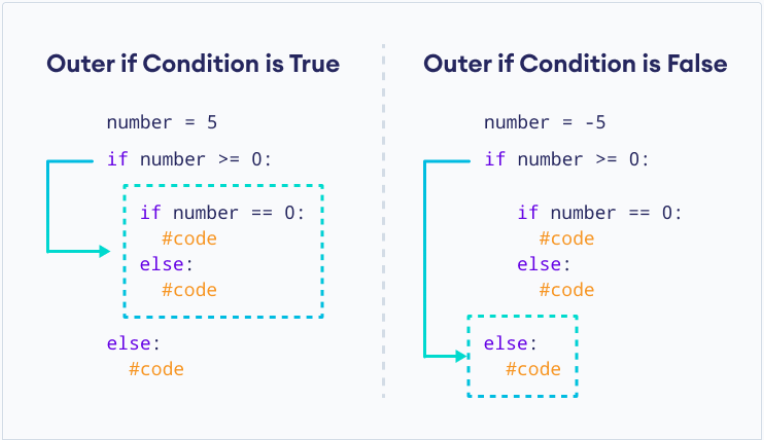

In [ ]:
number = 0

# outer if statement
if number >= 0:
    # inner if statement
    if number == 0:
      print('Number is 0')

    # inner else statement
    else:
        print('Number is positive')

# outer else statement
else:
    print('Number is negative')

Number is 0


In [ ]:
amount = 2500
print('Amount = ',amount)
if amount > 10000:
   discount = amount * 20 / 100
else:
   if amount > 5000:
      discount = amount * 10 / 100
   else:
      if (amount > 1000):
         discount = amount * 5 / 100
      else:
         discount = 0

print('Payable amount = ',amount - discount)

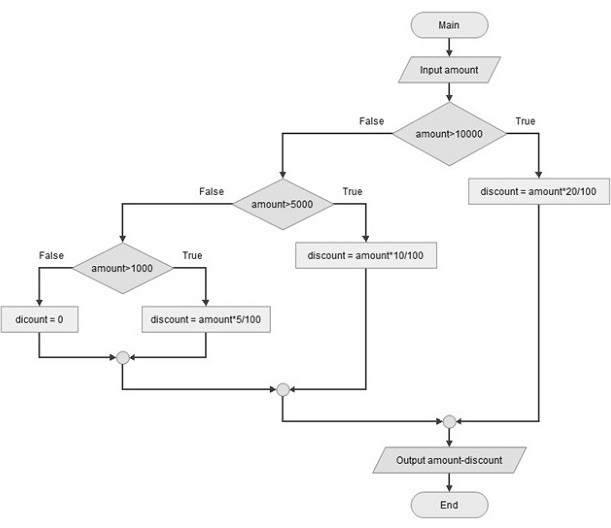

## Loops

### for

In [ ]:
list_1 = [121,4562,3456,44,58,6567,756,567,955]

for i in range(len(list_1)):
  if i%2 == 0:
    pass
  else:
    print(list_1[i])



0
1
2
3
4
5
6
7
8


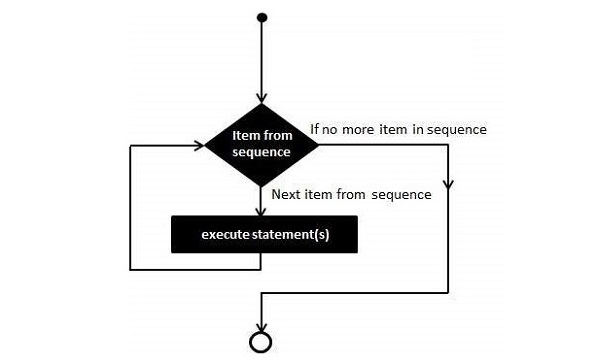

In [ ]:
# Syntax
for val in sequence:
  # body of the loop

In [ ]:
languages = ['Swift', 'Python', 'Go']

# access elements of the list one by one
for language in languages:
    print(language)

Swift
Python
Go


In [ ]:
# Indentation in Loop

languages = ['Swift', 'Python', 'Go']

# Start of loop
for lang in languages:
  print(lang)
  print('-----')

languages[1]

# End of for loop
print('Last statement')

'Python'

In [ ]:
# Loop Through a String

language = 'Python'

# iterate over each character in language
for char in language:
    print(char)

'y'

In [ ]:
# for Loop with Range Objects
# range([start], stop, [step])

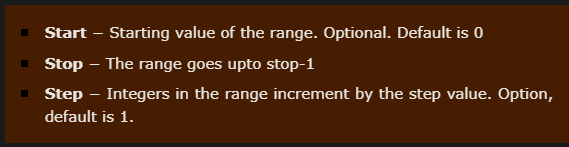

In [ ]:
for num in range(5):
  print(num)


0
1
2
3
4


In [ ]:
for num in range(1, 10):
   print(num)

In [ ]:
for num in range(1, 10, 3):
   print(num)

In [ ]:
# iterate from i = 0 to i = 3
0 1 2 3

for i in range(4):
    print(i)

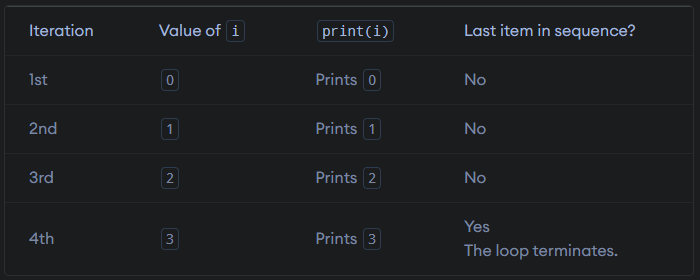

In [ ]:
#  for Loop with Tuples
numbers = (34,54,67,21,78,97,45,44,80,19)
total = 0
for num in numbers:
   total += num
print("Total =", total)

Total = 539


In [ ]:
#  for Loop with Lists

numbers = [34,54,67,21,78,97,45,44,80,19]
total = 0
for num in numbers:
  if num%2 == 0:
  print(num)

In [ ]:
# for Loop with Dictionaries

numbers = {10:"Ten",
           20:"Twenty",
           30:"Thirty",
           40:"Forty"}
for x in numbers:
   print(numbers[x])

Ten
Twenty
Thirty
Forty


In [ ]:
numbers = {10:"Ten", 20:"Twenty", 30:"Thirty",40:"Forty"}
for x in numbers:
   print(x,":",numbers[x])

10 : Ten
20 : Twenty
30 : Thirty
40 : Forty


In [ ]:
numbers = {10:"Ten", 20:"Twenty", 30:"Thirty",40:"Forty"}
for x in numbers.items():
   print(x)

(10, 'Ten')
(20, 'Twenty')
(30, 'Thirty')
(40, 'Forty')


In [ ]:
-- 1 2 3
-- 4 5 6
i = 1 4
1 5
1 6
--
2 4
2 5
2 6

In [ ]:
inner_count = 0
outer_coount = 0
for i in range(1,4):
  for j in range(4,7):
    print(i,j)
    inner_count = inner_count + 1

  outer_coount = outer_coount + 1

print(inner_count,outer_coount)


1 4
1 5
1 6
2 4
2 5
2 6
3 4
3 5
3 6
9 3


In [ ]:
list_1 = [2]

for element in list_1:
  list_1.append(element)

[2,2]
[2,2,2]
[2,2,2,2]

### while

In [ ]:
#  Syntax

while condition:

  # body of while loop

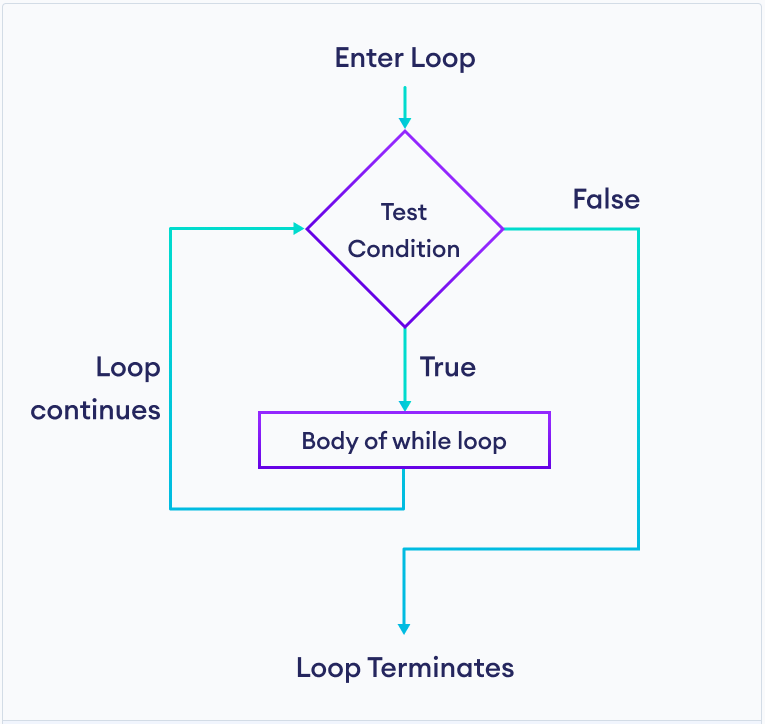

In [ ]:
for i in range(4):
  print(i)

num = 0
while num <= 3:
  print(num)
  # num = num + 1
  num+=1

# while number <= 3:
#     print(number)
#     number = number + 1

0
1
2
3


In [ ]:
# Infinite while Loop

age = 32

money = 100

# The test condition is always True
while age > 18:
  print('You can vote')

In [ ]:
age = 32

# the test condition is always True
while True:
    print('You can vote')
    break


### break

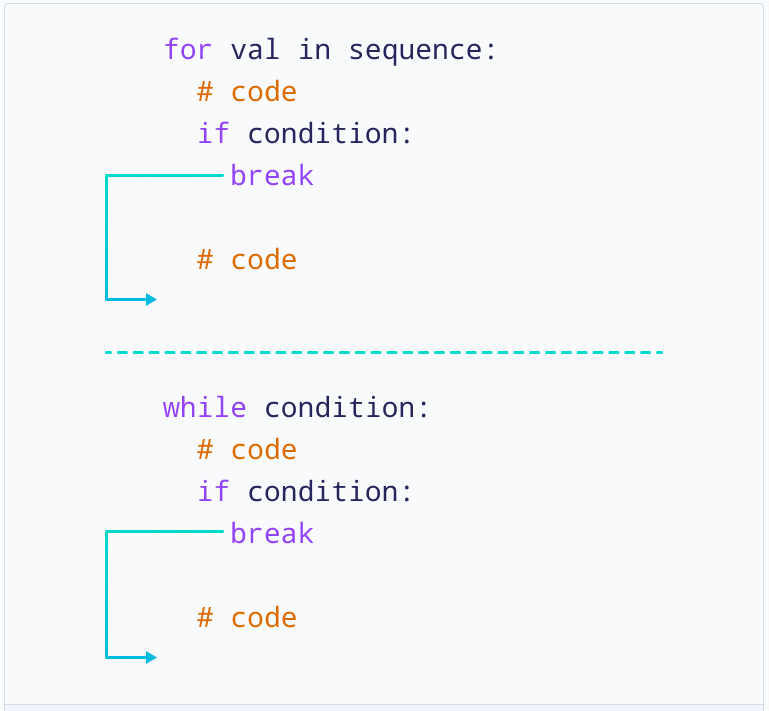

In [ ]:
list_1 = [1,55,66,2,3,4,5,6]

for i in list_1:
  print(i)
  if i == 55:
    break

1
55


In [ ]:
for i in range(3):  # Outer loop
    for j in range(3):  # Inner loop
        if j == 1:
          break  # Only breaks the inner loop
        print(f"i={i}, j={j}")


### continue

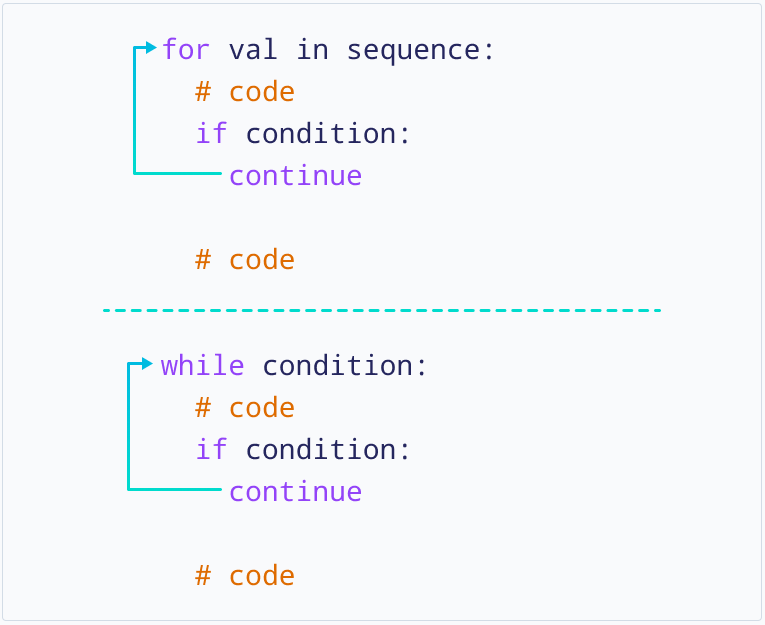

In [ ]:
for i in range(5):
    if i == 3:
        continue
    print(i)

### pass


In [ ]:
def function(args):
  pass

In [ ]:
def check_o_e(num):
  if num%2 == 0:
    print('even')
  else:
    print('odd')


check_o_e(33)

odd


# Functions

A Python function is a block of organized, reusable code that is used to perform a single, related action. Functions provide better modularity for your application and a high degree of code reusing.

In [ ]:
# def greet():
#   print('Hello World!')
#   print('bye!')

In [ ]:
greet()


print('aaaaaa')

Hello World!
bye!


In [ ]:
def greet():
  print('HW!')


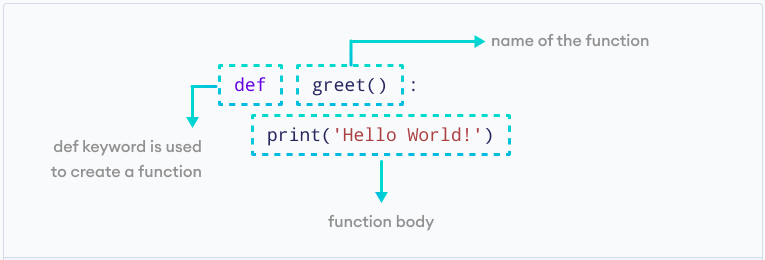

In [ ]:
# call the function
greet()

HW!


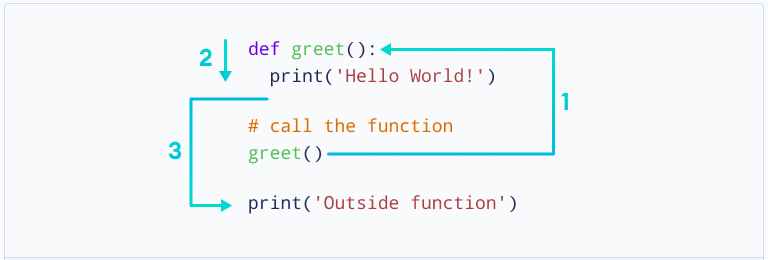

In [ ]:
# Function Arguments

def greet(name):
    print("Hello ", name)

# pass argument
greet("John")



Hello  John


In [ ]:
# function with two arguments
def add_numbers(num1, num2):
    sum = num1 + num2
    print("Sum: ", sum)


# function call with two values
add_numbers(22,33)


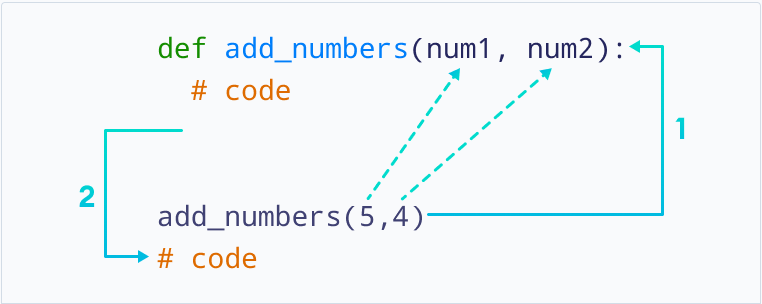

In [ ]:
# return Statement

# function definition
def find_square(num):
    result = num * num
    return result

# function call
num1 = int(input())
res = find_square(num1)

print(res)
# print('Square:', square)

11
121


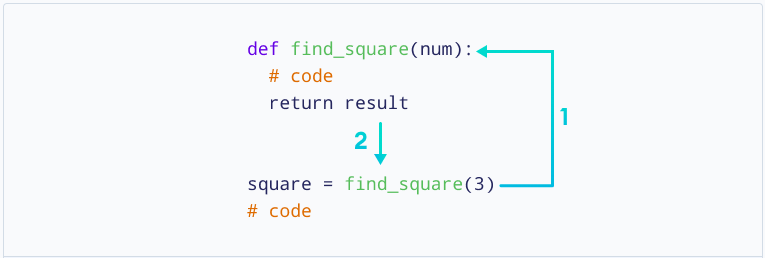

In [ ]:
# pass Statement

def future_function():
  pass

# this will execute without any action or error
future_function()


In [ ]:
# Library Function
import math

# sqrt computes the square root
square_root = math.sqrt(4)

print("Square Root of 4 is",square_root)

Square Root of 4 is 2.0


In [ ]:
# pow() comptes the power
power = pow(2, 3)

print("2 to the power 3 is",power)

In [ ]:
# Argument with Default Values

def add_numbers(a=1, b=9):
  sum = a + b
  print('Sum:', sum)

In [ ]:
# function call with two arguments
add_numbers()

Sum: 10


In [ ]:
#  function call with one argument
add_numbers(a = 2)

In [ ]:
# function call with no arguments
add_numbers()

In [ ]:
# Arbitrary Arguments

# program to find sum of multiple numbers

def find_sum(*numbers):
  result = 0

  for num in numbers:
    result = result + num

  print("Sum = ", result)


In [ ]:
# function call with 3 arguments
find_sum(1, 2)

Sum =  3


In [ ]:
# function call with 2 arguments
find_sum(4, 9)

In [ ]:
# Variable Scope
# Local Variables

def greet():

  # local variable
  message = 'Hello'

  print('Local', message)

greet()

# try to access message variable
# outside greet() function
print(message)

Local Hello


NameError: name 'message' is not defined

In [ ]:
# declare global variable
message = 'Hello'

def greet():
    # declare local variable
    print('Local', message)

greet()
print('Global', message)

Local Hello
Global Hello


In [ ]:
# global variable
c = 1

def add():

  # increment c by 2
  c = c + 2

  print(c)

add()

In [ ]:
# global variable
c = 1

def add():

  # use of global keyword
  global c

  # increment c by 2
  c = c + 2

  print(c)

add()

The basic rules for global keyword in Python are:

* When we create a variable inside a function, it is local by default.
* When we define a variable outside of a function, it is global by default. You don't have to use the global keyword.
* We use the global keyword to modify (write to) a global variable inside a function.
* Use of the global keyword outside a function has no effect.

# Modules

Module is a file that contains code to perform a specific task. A module may contain variables, functions, classes etc.
Python's standard library comes bundled with a large number of modules. They are called built-in modules. Most of these built-in modules are written in C (as the reference implementation of Python is in C), and pre-compiled into the library. These modules pack useful functionality like system-specific OS management, disk IO, networking, etc.

In [ ]:
# import standard math module
import math

# use math.pi to get value of pi
print(math.pi)

3.141592653589793


In [ ]:
# import module by renaming it
import math as m

print(m.pi)

3.141592653589793


In [ ]:
# import only pi from math module
from math import pi

print(pi)

3.141592653589793


In [ ]:
 # import all names from the standard module math
from math import *

print("The value of pi is", pi)

In [ ]:
print(dir(math))

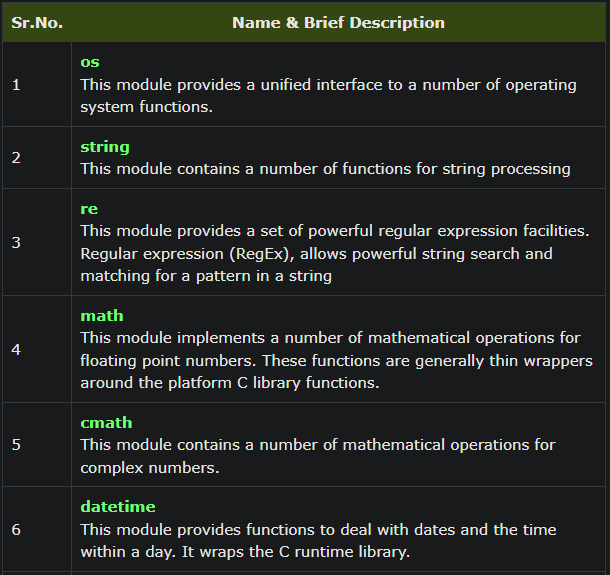

# Package

A package is a container that contains various functions to perform specific tasks. For example, the math package includes the sqrt() function to perform the square root of a number.

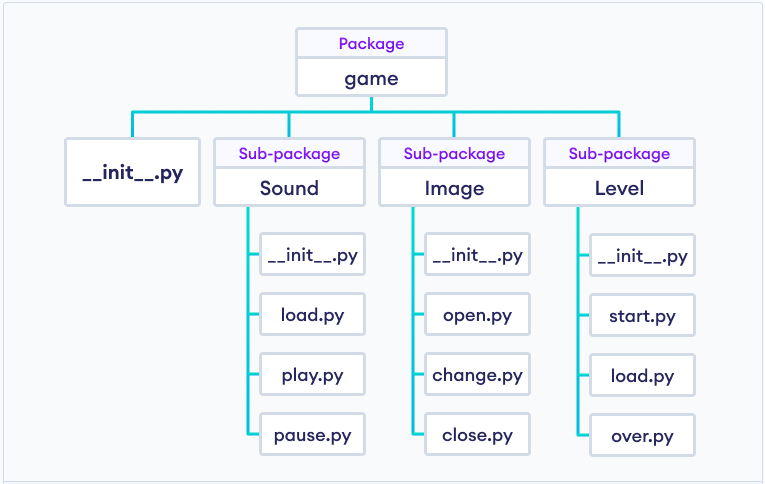

In [ ]:
import Game.Level.start

In [ ]:
Game.Level.start.select_difficulty(2)

In [ ]:
from Game.Level import start

In [ ]:
start.select_difficulty(2)

In [ ]:
from Game.Level.start import select_difficulty

In [ ]:
select_difficulty(2)

# Main function

Some programming languages have a special function called main() which is the execution point for a program file. Python interpreter, however, runs each line serially from the top of the file and has no explicit main() function.

Python offers other conventions to define the execution point. One of them is using the main() function and the \___name\___ property of a python file.

The \___name\___ variable is a special builtin Python variable that shows the name of the current module.

In [ ]:
def main():
    print("Hello World")

if __name__=="__main__":
    main()